<h1 align="center">The Bootstrap Method</h1>

We can use the bootstrap method to construct a confidence interval around any statistical measure.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

For examples, let's say we have an array of values and their mean.

In [2]:
data = pd.Series(np.random.rand(100))
actual_mean = data.mean()
print('{:.3f}'.format(actual_mean))

0.507


How stable is this measure? To answer this, we'll sample with replacements from ``data`` a large number of times and calculate the mean of each of them. Note that each bootstrap sample should have the same number of values as the original sample (but it may not include all of the original data because of repititions). The reason the sizes must be same is that the variances will be different otherwise.

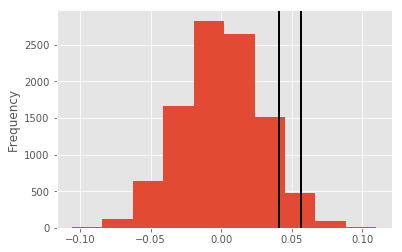

In [5]:
def calc_sample_means(data, n):
    """Make n bootstrap samples from data and calculate their means."""
    sample_means = []
    for _ in range(n):
        sample_data = data.sample(n=data.shape[0], replace=True)
        sample_means.append(sample_data.mean())
        
    return pd.Series(sample_means)

means = calc_sample_means(data, 10000)
errors = means - actual_mean
alpha = 0.95
delta = (1 - alpha) / 2.0
error_low, error_high = errors.quantile([alpha - delta, alpha + delta]).values.tolist()

ax = errors.plot(kind='hist')
plt.axvline(x=error_low, color='black', linewidth=2.0)
plt.axvline(x=error_high, color='black', linewidth=2.0)

So the error of bootstrap sample means) are normally distributed around the sample means. This is due to the Law of Large Numbers.

We can find the confidence intervals by sorting the error in bootstrap means and then selecting the $[alpha-(1-alpha) /2, alpha + (1-alpha/2)]$ percentile values.

In [6]:
mean_low, mean_high = actual_mean - error_low, actual_mean + error_high
print('95% confidence interval: [{:.3f}, {:.3f}]'.format(mean_low, mean_high))

95% confidence interval: [0.466, 0.563]


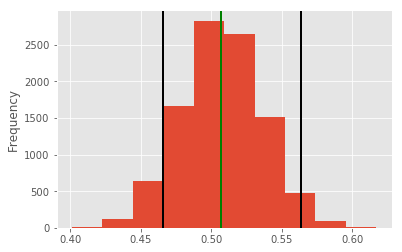

In [7]:
ax = means.plot(kind='hist')
plt.axvline(x=actual_mean, color='green', linewidth=2.0)
plt.axvline(x=mean_low, color='black', linewidth=2.0)
plt.axvline(x=mean_high, color='black', linewidth=2.0)

**Note that it is incorrect to calculate percentiles on the sample means directly.This is because it depends on a particular bootstrap distribution being a good approximation to the true distribution of x.**

# Bootstrap applied to Machine Learning

In this section, we take the IRIS dataset and build a simple Gaussian Naive Bayes Model.

In [8]:
import seaborn as sns
import os
data_df = sns.load_dataset('iris')

In [9]:
data_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


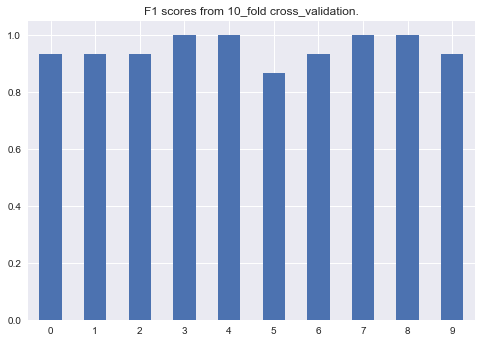

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

estimator = GaussianNB()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(
    estimator, 
    data_df.drop('species', axis=1).values,
    data_df.species.values,
    cv = cv,
    scoring='f1_macro'
)

scores = pd.Series(data=scores, name='cv_f1_scores')
ax = scores.plot(kind='bar', rot=0, title='F1 scores from 10_fold cross_validation.')

In [25]:
mean_score = scores.mean()
print('{:.3f}'.format(mean_score))

0.953


Now we'll use the bootstrap method to construct a confidence interval around this score.

# Percentiles

The simplest approach follows the percentile based calcutaion for the mean estimates.

In [28]:
from sklearn.metrics import f1_score

def gen_bootstrap_samples(data_df, n):
    """
    Make n bootstrap samples from data_df assuming 10 fold CV. 
    Return a generator for train and test DataFrames.
    """
    
    assert n > 1
    
    for _ in range(n):
        # Since we used 10-fold cross-validation
        train_df = data_df.sample(frac=0.9, replace=True)

        test_df_candidates = data_df.drop(train_df.index, axis=0)
        test_df = test_df_candidates.sample(frac=0.1, replace=True)
        
        yield train_df, test_df
        

        
def get_score(train_df, test_df):
    """
    Calculate f1 macro score by training a model using train_df 
    and evaluating predictions against test_df.
    """
    
    estimator = GaussianNB().fit(train_df.drop('species', axis=1).values, train_df.species.values)
    predictions = estimator.predict(test_df.drop('species', axis=1).values)
    
    return f1_score(test_df.species.values, predictions, average='macro')


def bootstrap_f1_scores(data_df, n):
    """Calculate and return f1 scores for n bootstrap samples using data_df, assuming 10 fold cross validation."""
    
    scores = []
    
    for train_df, test_df in gen_bootstrap_samples(data_df, n):
        score = get_score(train_df, test_df)
        scores.append(score)
        
    return pd.Series(scores)


bootstrap_scores = bootstrap_f1_scores(data_df, n=1000)

C:\Users\dkailthy\AppData\Local\Miniconda\envs\mbfi\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dkailthy\AppData\Local\Miniconda\envs\mbfi\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


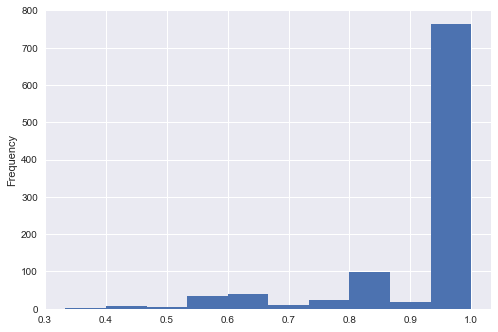

In [29]:
bootstrap_scores.plot(kind='hist')

In [30]:
score_errors = bootstrap_scores - mean_score
alpha = 0.95
delta = (1 - alpha) / 2.0
error_low, error_high = score_errors.quantile([alpha - delta, alpha + delta]).values.tolist()
score_low, score_high = mean_score - error_low, mean_score + error_high

print('95% Confidence interval for mean score {:.3f} is [{:.3f}, {:.3f}]'.format(mean_score, score_low, score_high))

95% Confidence interval for mean score 0.953 is [0.906, 1.000]
